# Monte Carlo Simulations

Here we implement a simple Monte Carlo algorithm for a contact process. The master equation is

\begin{equation}
\omega_i(\eta) = \frac{\lambda}{2(\lambda + 1)}(1 - \eta_i) \sum_\delta \eta_{i+\delta} + \frac{1}{\lambda + 1}\eta_i 
\end{equation}

The occupation and annihilation rates thus obey the ratio:

\begin{equation}
\frac{0 \rightarrow 1}{1 \rightarrow 0} = \frac{n \lambda}{2}
\end{equation}

In [18]:
import matplotlib.pyplot as plt
import matplotlib as mp
import numpy as np
import random
import scipy.interpolate as inter
import copy

Here we implement the procedure to shuffle the chain, which decides wether we should change a site or not

In [19]:
# Decides wheter the site will be inverted or not.

def shuffle(chain, lamb, site, SIZE):

    if chain[site] == 0:
        if chain[(site + random.choice([-1, 1])) % SIZE] == 1:
            chain[site] = 1

    elif random.random() < 1/lamb:
        chain[site] = 0

    return chain[site]

This is a function to initialize the chain in a randomized state

In [20]:
# Generates the initial state. Uncomment to begin with a random initial state

def randomize_chain(initial, SIZE):

    chain = []

    for i in range(SIZE):
        chain.append(initial)

    return chain

Here we implement the Monte Carlo algorithm itself

In [21]:
# Time Evolution

def time_evolution(lamb):

    SIZE = 40
    STEPS = 500

    # Initializes the chain
    chain = randomize_chain(1, SIZE)

    # Initializes the time evolution matrix. Each column represents the chain at a certain time. Each row
    # represents the evoution of a site.
    evolution_list = [copy.deepcopy(chain)]

    # Monte Carlo Steps
    for i in range(STEPS):

        site = random.randint(0, SIZE - 1)
        chain[site] = shuffle(chain, lamb, site, SIZE)
        evolution_list.append(copy.deepcopy(chain))

    # Plots the time evolution of the chain
    fig, axis = plt.subplots()
    custom_map = mp.colors.ListedColormap([(0.33, 0.42, 0.18), 'gray']) # Color map
    axis.matshow(list(map(list, zip(*evolution_list))), cmap=custom_map, aspect=8)  # Plots the transpose

    axis = plt.gca()  # Current axis

    axis.set(xlabel='Monte Carlo Steps', ylabel='Sites', title='Evolution of occuped sites')

    # Aligns the ticks with each site, with appropiate lenght. THe -.5 offset is necessary
    axis.set_xticks(np.arange(-.5, STEPS, STEPS/100), minor=True)
    axis.set_yticks(np.arange(-.5, SIZE, 1), minor=True)
    axis.set_xticks(np.arange(-.5, STEPS, STEPS/5))  # The third argument represents a new tick each X units.
    axis.set_yticks(np.arange(-.5, SIZE, SIZE/8))

    # Color and grid type
    axis.grid(which='minor', linestyle='-', linewidth=0.1, color='w')
    axis.grid(which='major', linestyle='-', linewidth=0.1, color='w')

    # Labels in the top and bottom of the frame
    axis.set_xticklabels(np.arange(0, STEPS + 1, STEPS/5))
    axis.set_yticklabels(np.arange(0, SIZE + 1, SIZE/8))

    # This erases the labels in the x-axis
    plt.tick_params(axis='x', which='minor', bottom=False, top=False, labelbottom=False)

    plt.show()
    fig.savefig("Time Evolution %d .png" % lamb, dpi=250)

Below we plot the evolution of chain in each Monte Carlo Step for $\lambda = 2$. We begin with a single occupied state in the center of the chain. Occupied states are drawn in gray color, vacant sites are green. Each square represents $100$ Monte Carlo Steps. Each column is the chain at a certain point in time.

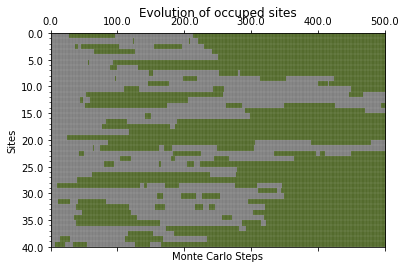

In [22]:
time_evolution(2)

Here we finally make some pretty plots to study the phase transition in the system.

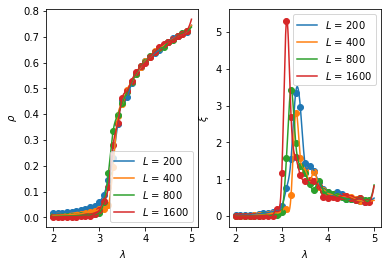

In [23]:
# Main function

def main():

    # Different chain sizes
    SIZE = [200, 400, 800, 1600]
    STEPS = 2000000
    RELAX = 500000
    
    # Plots for the density and the variance
    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.set(xlabel=r'$\lambda$', ylabel=r'$\rho$')
    ax2.set(xlabel=r'$\lambda$', ylabel=r'$\xi$')

    # List with magnetization at each temperature

    for j in range(len(SIZE)):

        density_list = []
        variance_list = []
        lambda_list = []

        # We perform several, Monte Carlo simulations so we can plot the system density
        # and variance as funciton of lambda
        
        for lamb in np.arange(2.0, 5.0, 0.1):

            # Initializes the relevant variables
            dens = 1
            num = SIZE[j]
            density = 0
            var1 = 0
            var2 = 0

            chain = randomize_chain(1, SIZE[j])  # Initializes the chain

            for i in range(STEPS):

                # Picks a random site
                site = random.randint(0, SIZE[j] - 1)

                # Updates the chain
                aux = chain[site]
                chain[site] = shuffle(chain, lamb, site, SIZE[j])

                # Avoids the absorbing states
                if num < 1:
                    chain[site] = 1

                # Updates the density and the number of occupied sites
                if aux != chain[site]:
                    dens += (2.0 * chain[site] - 1) / SIZE[j]
                    num += (2.0 * chain[site] - 1)

                # Doesn't update any quantity during the relaxation phase
                if i > RELAX:
                    density += dens
                    var1 += dens * SIZE[j]
                    var2 += (dens * SIZE[j]) ** 2

            # Updates the density and variance record
            lambda_list.append(lamb)
            density_list.append(density/(STEPS - RELAX))
            var1, var2 = var1/(STEPS - RELAX), var2/(STEPS - RELAX)
            variance_list.append((var2 - var1 ** 2) / SIZE[j])

        # Plots the density
        fd = inter.InterpolatedUnivariateSpline(lambda_list, density_list)
        xnew = np.linspace(2.0, 5.0, 500)
        ax1.plot(xnew, fd(xnew), label=r'$L$ = %d' % SIZE[j])
        ax1.scatter(lambda_list, density_list)

        # Plots the variance
        fv = inter.InterpolatedUnivariateSpline(lambda_list, variance_list)
        xnew = np.linspace(2.0, 5.0, 500)
        ax2.scatter(lambda_list, variance_list)
        ax2.plot(xnew, fv(xnew), label=r'$L$ = %d' % SIZE[j])

    # Plot legend location
    ax1.legend(loc='lower right')
    ax2.legend(loc='upper right')
    plt.show()
    
main()

On the left we can observe the results for the chain density, the order parameter of the system. We can clearly observe the finite size effects of the system: for smaller values of $L$ we have a smoother transition between the two phases. Or rather, it's no clear at all that the system exhibits a phase transition. However, as we increase the size of the chain, approaching the maximum value of our simulations, we can verify that there's a sudden transition around the critical point, where the density assumes non-zero values.

On the right we plot the variance of the system, which also exhibits a sudden jump at the critical point. This behaviour makes a lot of sense: it's almost zero in the inactive phase, since the system fluctuates around the absorbing state. It's a bit higher for the active phase, since the system presents a stable behaviour around a certain density, but it still has some fluctuations due to possible spontaneous annihilation. And it peaks around the critical point because the fluctuations are the biggest there, as we saw in the first simulations.  